# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 

## Homework 5: Logistic Regression, High Dimensionality and PCA


**Harvard University**<br/>
**Fall 2018**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader

<hr style="height:2pt">



In [1]:
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas  https://canvas.harvard.edu/courses/42693/pages/homework-policies-and-submission-instructions.
- Restart the kernel and run the whole notebook again before you submit. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.

Names of people you have worked with goes here: 

<hr style="height:2pt">

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

import math
from scipy.special import gamma

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

from IPython.display import display


<div class='theme'> Cancer Classification from Gene Expressions </div>

In this problem, we will build a classification model to distinguish between two related classes of cancer, acute lymphoblastic leukemia (ALL) and acute myeloid leukemia (AML), using gene expression measurements. The data set is provided in the file `data/dataset_hw5_1.csv`. Each row in this file corresponds to a tumor tissue sample from a patient with one of the two forms of Leukemia. The first column contains the cancer type, with 0 indicating the ALL class and 1 indicating the AML class. Columns 2-7130 contain expression levels of 7129 genes recorded from each tissue sample. 

In the following questions, we will use linear and logistic regression to build classification models for this data set. We will also use Principal Components Analysis (PCA) to reduce its dimensions. 



<div class='exercise'><b> Question 1 [25 pts]: Data Exploration </b></div>

First step is to split the observations into an approximate 50-50 train-test split. Below is some code to do this for you (we want to make sure everyone has the same splits).

In [3]:
np.random.seed(9002)
df = pd.read_csv('data/dataset_hw5_1.csv')
msk = np.random.rand(len(df)) < 0.5
data_train = df[msk]
data_test = df[~msk]

**1.1:** Take a peek at your training set: you should notice the severe differences in the measurements from one gene to the next (some are negative, some hover around zero, and some are well into the thousands).  To account for these differences in scale and variability, normalize each predictor to vary between 0 and 1.


In [4]:
display(data_train.head())
display(data_test.head())

,Cancer_type,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
0,0,-214,-153,-58,88,-295,-558,199,-176,252,...,185,511,-125,389,-37,793,329,36,191,-37
2,0,-106,-125,-76,168,-230,-284,4,-122,70,...,156,649,57,504,-26,250,314,14,56,-25
5,0,-67,-93,84,25,-179,-323,-135,-127,-2,...,48,224,60,194,-10,291,41,8,-2,-80
9,0,-476,-213,-18,301,-403,-394,-42,-144,98,...,241,1214,127,255,50,1701,1108,61,525,-83
10,0,-81,-150,-119,78,-152,-340,-36,-141,96,...,186,573,-57,694,-19,636,205,17,127,-13


,Cancer_type,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
1,0,-135,-114,265,12,-419,-585,158,-253,49,...,240,835,218,174,-110,627,170,-50,126,-91
3,0,-72,-144,238,55,-399,-551,131,-179,126,...,30,819,-178,151,-18,1140,482,10,369,-42
4,0,-413,-260,7,-2,-541,-790,-275,-463,70,...,289,629,-86,302,23,1798,446,59,781,20
6,0,-92,-119,-31,173,-233,-227,-49,-62,13,...,213,583,3,530,-39,696,302,24,74,-11
7,0,-107,-72,-126,149,-205,-284,-166,-185,1,...,120,722,20,332,-5,195,59,31,116,-18


In [5]:
min_vals = data_train.min()
max_vals = data_train.max()

data_train = (data_train - min_vals)/(max_vals - min_vals)
data_test = (data_test - min_vals)/(max_vals - min_vals)

In [6]:
display(data_train.head())
display(data_test.head())
display(data_train.describe())
display(data_test.describe())

,Cancer_type,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
0,0.0,0.466192,0.739726,0.255814,0.246154,0.433190,0.240418,0.880427,0.625850,0.928074,...,0.385445,0.268542,0.398126,0.161897,0.677778,0.323241,0.322609,0.751381,0.069457,0.381720
2,0.0,0.658363,0.794521,0.213953,0.421978,0.573276,0.717770,0.741637,0.748299,0.505800,...,0.307278,0.356777,0.824356,0.206978,0.718519,0.081478,0.309565,0.629834,0.027597,0.446237
5,0.0,0.727758,0.857143,0.586047,0.107692,0.683190,0.649826,0.642705,0.736961,0.338747,...,0.016173,0.085038,0.831382,0.085457,0.777778,0.099733,0.072174,0.596685,0.009612,0.150538
9,0.0,0.000000,0.622309,0.348837,0.714286,0.200431,0.526132,0.708897,0.698413,0.570766,...,0.536388,0.718031,0.988290,0.109369,1.000000,0.727516,1.000000,0.889503,0.173023,0.134409
10,0.0,0.702847,0.745597,0.113953,0.224176,0.741379,0.620209,0.713167,0.705215,0.566125,...,0.388140,0.308184,0.557377,0.281458,0.744444,0.253339,0.214783,0.646409,0.049612,0.510753


,Cancer_type,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
1,0.0,0.606762,0.816047,1.006977,0.079121,0.165948,0.193380,0.851246,0.451247,0.457077,...,0.533693,0.475703,1.201405,0.077617,0.407407,0.249332,0.184348,0.276243,0.049302,0.091398
3,0.0,0.718861,0.757339,0.944186,0.173626,0.209052,0.252613,0.832028,0.619048,0.635731,...,-0.032345,0.465473,0.274005,0.068601,0.748148,0.477738,0.455652,0.607735,0.124651,0.354839
4,0.0,0.112100,0.530333,0.406977,0.048352,-0.096983,-0.163763,0.543060,-0.024943,0.505800,...,0.665768,0.343990,0.489461,0.127793,0.900000,0.770703,0.424348,0.878453,0.252403,0.688172
6,0.0,0.683274,0.806262,0.318605,0.432967,0.566810,0.817073,0.703915,0.884354,0.373550,...,0.460916,0.314578,0.697892,0.217170,0.670370,0.280053,0.299130,0.685083,0.033178,0.521505
7,0.0,0.656584,0.898239,0.097674,0.380220,0.627155,0.717770,0.620641,0.605442,0.345708,...,0.210243,0.403453,0.737705,0.139553,0.796296,0.056990,0.087826,0.723757,0.046202,0.483871


,Cancer_type,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
count,40.00000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,...,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000
mean,0.37500,0.640347,0.719472,0.369477,0.512253,0.529472,0.550653,0.654253,0.581803,0.535615,...,0.385916,0.351822,0.656206,0.173726,0.698519,0.334762,0.283348,0.615608,0.162620,0.404570
std,0.49029,0.182889,0.186767,0.237206,0.243956,0.231075,0.214332,0.216589,0.228836,0.231285,...,0.234882,0.195379,0.217202,0.154501,0.201592,0.204001,0.171412,0.200119,0.202527,0.199781
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.596530,0.631115,0.201744,0.325824,0.386853,0.408101,0.547153,0.484127,0.342807,...,0.247305,0.213235,0.556792,0.104175,0.602778,0.210597,0.200870,0.506906,0.057054,0.243280
50%,0.00000,0.653025,0.745597,0.323256,0.553846,0.584052,0.542683,0.683986,0.634921,0.573086,...,0.370620,0.337596,0.715457,0.143865,0.737037,0.302760,0.281739,0.607735,0.085271,0.416667
75%,1.00000,0.731762,0.844423,0.500000,0.720330,0.683728,0.713850,0.753381,0.739796,0.725058,...,0.498652,0.407289,0.813232,0.195904,0.856481,0.434328,0.342391,0.708564,0.176434,0.512097
max,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


,Cancer_type,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
count,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,...,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000
mean,0.303030,0.641055,0.733737,0.371388,0.409524,0.512409,0.479516,0.744937,0.606473,0.533502,...,0.328188,0.387352,0.664112,0.141442,0.679686,0.297215,0.322661,0.597355,0.120583,0.429456
std,0.466694,0.165245,0.189658,0.335398,0.239065,0.298177,0.309424,0.174231,0.222876,0.187403,...,0.271523,0.194909,0.193956,0.138439,0.180964,0.194876,0.186667,0.296720,0.179463,0.233766
min,0.000000,0.112100,0.174168,-0.562791,-0.026374,-0.096983,-0.198606,0.489680,-0.024943,0.153132,...,-0.269542,0.021739,0.257611,0.014504,0.266667,0.029386,0.035652,-0.591160,-0.010853,-0.440860
25%,0.000000,0.560498,0.618395,0.255814,0.232967,0.312500,0.240418,0.620641,0.519274,0.406032,...,0.164420,0.268542,0.578454,0.076833,0.551852,0.203028,0.184348,0.508287,0.046202,0.349462
50%,0.000000,0.683274,0.767123,0.374419,0.373626,0.566810,0.496516,0.716726,0.625850,0.494200,...,0.239892,0.350384,0.662763,0.103489,0.677778,0.269368,0.322609,0.607735,0.074729,0.451613
75%,1.000000,0.749110,0.872798,0.504651,0.558242,0.698276,0.736934,0.839146,0.752834,0.635731,...,0.463612,0.475703,0.768150,0.163073,0.796296,0.330365,0.423478,0.751381,0.090853,0.575269
max,1.000000,0.873665,1.013699,1.116279,0.923077,1.314655,0.954704,1.243416,0.970522,0.928074,...,0.846361,0.872123,1.201405,0.769502,1.007407,0.838379,0.824348,1.187845,0.791628,0.795699


From the above statistics of train dataframe, we can see that training dataset is normalised. Test dataset still has some negative values, since we are useing max and min from train dataset to normalise the test set. <br/>

**1.2:** Notice that the results training set contains significantly more predictors than observations. Do you foresee a problem in fitting a classification model to such a data set?

In [7]:
data_train.shape

(40, 7130)

The training set is improper as it contains many more columns compared to number of samples. If we fit models to the given dataset, they will be highly overfitted. This is called the curse of dimensionality.

**1.3:** Lets explore a few of the genes and see how well they discriminate between cancer classes. Create a single figure with four subplots arranged in a 2x2 grid. Consider the following four genes: `D29963_at`, `M23161_at`, `hum_alu_at`, and `AFFX-PheX-5_at`. For each gene overlay two histograms of the gene expression values on one of the subplots, one histogram for each cancer type. Does it appear that any of these genes discriminate between the two classes well? How are you able to tell?

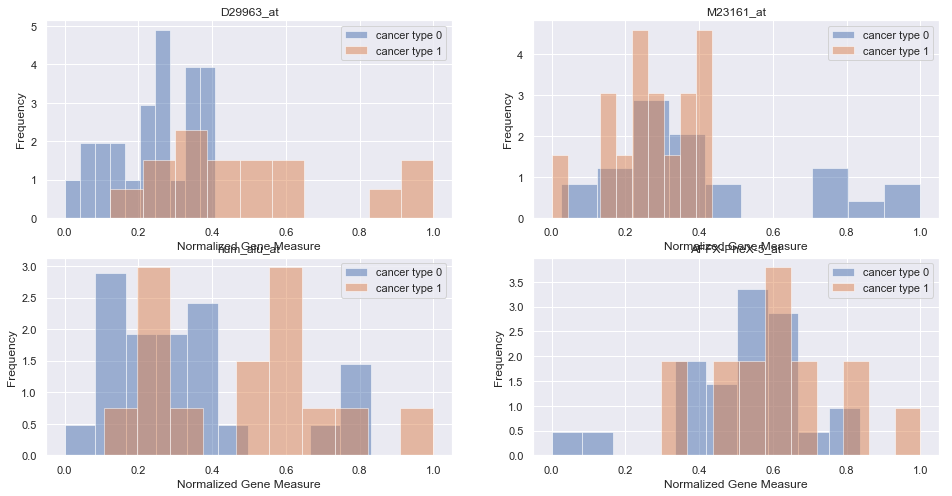

In [14]:
alpha=0.5

fig, ax = plt.subplots(2, 2, figsize=(16, 8))

cancer_type_0 = data_train[data_train['Cancer_type'] == 0]
cancer_type_1 = data_train[data_train['Cancer_type'] == 1]

# D29963_at
ax[0, 0].hist(cancer_type_0['D29963_at'], alpha=alpha, label='cancer type 0', normed=True)
ax[0, 0].hist(cancer_type_1['D29963_at'], alpha=alpha, label='cancer type 1', normed=True)
ax[0, 0].set_title('D29963_at')
ax[0, 0].set_xlabel('Normalized Gene Measure')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].legend()

# M23161_at
ax[0, 1].hist(cancer_type_0['M23161_at'], alpha=alpha, label='cancer type 0', normed=True)
ax[0, 1].hist(cancer_type_1['M23161_at'], alpha=alpha, label='cancer type 1', normed=True)
ax[0, 1].set_title('M23161_at')
ax[0, 1].set_xlabel('Normalized Gene Measure')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].legend()

# hum_alu_at
ax[1, 0].hist(cancer_type_0['hum_alu_at'], alpha=alpha, label='cancer type 0', normed=True)
ax[1, 0].hist(cancer_type_1['hum_alu_at'], alpha=alpha, label='cancer type 1', normed=True)
ax[1, 0].set_title('hum_alu_at')
ax[1, 0].set_xlabel('Normalized Gene Measure')
ax[1, 0].set_ylabel('Frequency')
ax[1, 0].legend()

# AFFX-PheX-5_at
ax[1, 1].hist(cancer_type_0['AFFX-PheX-5_at'], alpha=alpha, label='cancer type 0', normed=True)
ax[1, 1].hist(cancer_type_1['AFFX-PheX-5_at'], alpha=alpha, label='cancer type 1', normed=True)
ax[1, 1].set_title('AFFX-PheX-5_at')
ax[1, 1].set_xlabel('Normalized Gene Measure')
ax[1, 1].set_ylabel('Frequency')
ax[1, 1].legend();

From the above histograms, we may argue that `D29963_at` and `hum_alu_at` have slightly disjointed regions in the graph and may be singly able to differentiate between the cancer types. For the other two genes, the histograms for both cancer types seem to overlap and don't have distinctive regions. <br/> <br/>

If in any of the above plots, the frequency level of each cancer type was different or the gene measure was in different ranges, we could argue that that a gene is able to distinguish between different cancer types well. This may be said for different frequency levels of `D29963_at` but doesn't seem true in any other case.

It is also useful to note the shape of the individual distributions as well. For instance, `hum_alu_at` has a very bimodal distribution for type 1, whereas for 0 it is more unimodal. The same can be said for `M23161_at` to a lesser extent. Loosely speaking, the characteristics of the distributions could be used to compare the odds of a given gene expression value indicating 0 vs 1. 

Finally, it is worth noting in our solution that `density`/`normed` is not ensuring that the result matches the **true** continuous PDF, but rather simply scaling the counts of the values to turn it into a valid discrete density function determined solely by our samples. This helps us compare the two cancer types, as the number of samples from each cancer type is different. 

**1.4:** Since our data has dimensions that are not easily visualizable, we want to reduce the dimensionality of the data to make it easier to visualize. Using PCA, find the top two principal components for the gene expression data. Generate a scatter plot using these principal components, highlighting the two cancer types in different colors. How well do the top two principal components discriminate between the two classes? How much of the variance within the data do these two principal components explain?

In [15]:
# your code here
x_train, y_train = data_train.iloc[:,1:], data_train.iloc[:,0]
x_test, y_test = data_test.iloc[:,1:], data_test.iloc[:,0]

print("x train shape:", x_train.shape, "test shape:", x_test.shape)

# finding top 2 components
pca = PCA(n_components = 2).fit(x_train)
pca_x = pca.transform(x_train)

print("pca shape:", pca_x.shape)

x train shape: (40, 7129) test shape: (33, 7129)
pca shape: (40, 2)


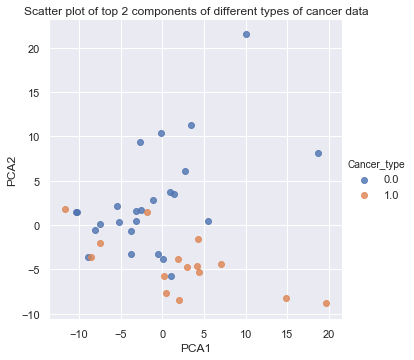

In [17]:
# your code here
# generating scatter plot
pca_df = pd.DataFrame(pca_x, columns=['PCA1', 'PCA2'])
pca_df['Cancer_type'] = y_train.values

sns.lmplot(x="PCA1", y="PCA2", hue='Cancer_type', data=pca_df, fit_reg=False)
plt.title('Scatter plot of top 2 components of different types of cancer data');

In [18]:
print( "Variance explained:", np.sum(pca.explained_variance_ratio_))

Variance explained: 0.2731782945208866


The first two principal components only show a limited capacity to discriminate between the two cancer types. As we can see in the plot, the two types often occupy the same regions in this "PC space." This is probably due to fact that only 27% of the variance can be explained by the first two PCs, so there is potentially more information we could exploit to classify the cancer type. 

**1.5** Plot the cumulative variance explained in the feature set as a function of the number of PCA-components (up to the first 50 components).  Do you feel 2 components is enough, and if not, how many components would you choose to consider?  Justify your choice in 3 or fewer sentences.  Finally, determine how many components are needed to explain at least 90% of the variability in the feature set.

number of components that explain at least 90% of the variance= 29


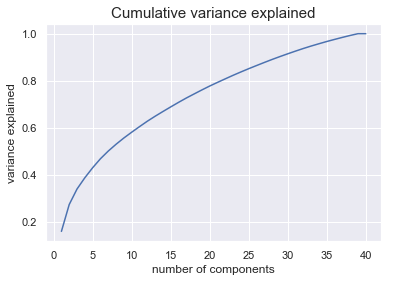

In [19]:
# your code here
# finding top 2 components
var_explained = []
total_comp = 40
pca = PCA(n_components = total_comp).fit(x_train)

plt.plot(np.linspace(1, total_comp, total_comp), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('variance explained')
plt.title('Cumulative variance explained',fontsize=15)

print("number of components that explain at least 90% of the variance=",\
    len(np.where(np.cumsum(pca.explained_variance_ratio_)<=0.9)[0])+1);

The number of principal components cannot be greater than the number of samples or the number of features. So in this case we can only get at most 40 PCs. As shown above, 29 components are needed to explain at least 90% of the variability in the feature set.

Two components are probably not enough in this context, since they can only explain 27% of the variance in the data. However, the number of components to consider ultimately depends on how we plan to use the transformed data. If we simply want to visualize the classes, then it is clear we cannot use more than three components. If we want to train a classifier on the transformed data (as we do later on), then we could consider a series of different numbers of PCs, and observe how the classifiation accuracy changes based on the number used. We could also consider the point of diminishing returns of adding new PCs, as demonstrated below.

Text(0.5, 1.0, 'Variance explained by each component')

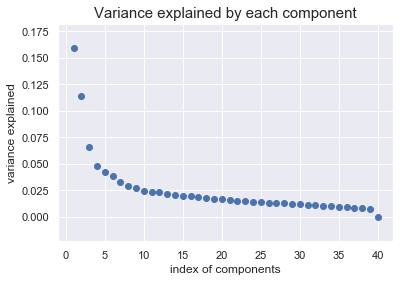

In [20]:
plt.scatter(range(1, 41), pca.explained_variance_ratio_)
plt.xlabel('index of components')
plt.ylabel('variance explained')
plt.title('Variance explained by each component',fontsize=15)

From the plot above we see approximately that the first 11 components explain relatively high variance, and the components afterward each explain similar amounts of variance. If we choose the first 11 components based on this observation, we would explain more than 60% of total variance.

In [21]:
print("The variance explained by first 11 components is",\
    np.sum(pca.explained_variance_ratio_[:11]))

The variance explained by first 11 components is 0.604403665357437


<div class='exercise'> <b> Question 2 [25 pts]: Linear Regression vs. Logistic Regression </b> </div>

In class we discussed how to use both linear regression and logistic regression for classification. For this question, you will work with a single gene predictor, `D29963_at`, to explore these two methods.


**2.1:** Fit a simple linear regression model to the training set using the single gene predictor D29963_at to predict cancer type and plot the histogram of predicted values. We could interpret the scores predicted by the regression model for a patient as an estimate of the probability that the patient has Cancer_type=1 (AML). Is there a problem with this interpretation?

shapes of x_train and x_test (40, 2) (33, 2)


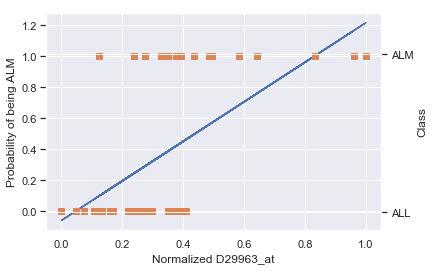

In [22]:
# your code here
single_x_train = sm.add_constant(x_train['D29963_at'])
single_x_test = sm.add_constant(x_test['D29963_at'])

print("shapes of x_train and x_test", single_x_train.shape, single_x_test.shape)

regr = OLS(y_train, single_x_train).fit()
y_train_pred = regr.predict(single_x_train)
y_test_pred = regr.predict(single_x_test)

fig = plt.figure();
host = fig.add_subplot(111)
par1 = host.twinx()

host.set_ylabel("Probability")
par1.set_ylabel("Class")

host.plot(x_train['D29963_at'], y_train_pred, '-');
host.plot(x_train['D29963_at'], y_train, 's');
host.set_xlabel('Normalized D29963_at')
host.set_ylabel('Probability of being ALM')

labels = ['ALL', 'ALM'];

# You can specify a rotation for the tick labels in degrees or with keywords.
par1.set_yticks( [0.082, 0.81]);
par1.set_yticklabels(labels);

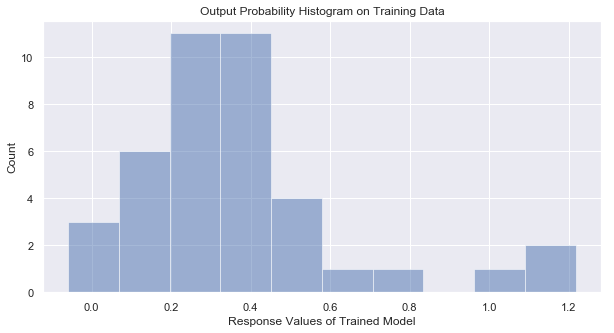

In [26]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
axs.hist(y_train_pred, alpha=0.5)
axs.set_xlabel("Response Values of Trained Model")
axs.set_ylabel("Count")
axs.set_title("Output Probability Histogram on Training Data")
plt.show()

If we take the regression prediction as probability of having Cancer Type 1, it is not clear how we will determine the presence of having cancer type 1 - is it 1-probability of Cancer type 1? We will also not be able to interpret response values $> 1$ or $< 0$.

**2.2:** The fitted linear regression model can be converted to a classification model (i.e. a model that predicts one of two binary classes 0 or 1) by classifying patients with predicted score greater than 0.5 into `Cancer_type`=1, and the others into the `Cancer_type`=0. Evaluate the classification accuracy of the obtained classification model on both the training and test sets.

In [28]:
# your code here
train_score = accuracy_score(y_train, y_train_pred>0.5)
test_score = accuracy_score(y_test, y_test_pred>0.5)
print("train score:", train_score, ", test score:", test_score)

train score: 0.8 , test score: 0.7575757575757576


We get 80% classification accuracy for training set and 75.75% for test set.

**2.3:**  Next, fit a simple logistic regression model to the training set. How do the training and test classification accuracies of this model compare with the linear regression model? If there are no substantial differences, why do you think this happens?

In [30]:
# your code here
logreg = LogisticRegression(C=100000, fit_intercept=False)
logreg.fit(single_x_train, y_train) 

# output 
y_train_pred_logreg = logreg.predict(single_x_train)
y_test_pred_logreg = logreg.predict(single_x_test)

y_train_pred_logreg_prob = logreg.predict_proba(single_x_train)[:,1]
y_test_pred_logreg_prob = logreg.predict_proba(single_x_test)[:,1]

train_score_logreg = accuracy_score(y_train, y_train_pred_logreg)
test_score_logreg = accuracy_score(y_test, y_test_pred_logreg)

print("train score:", train_score_logreg, "test score:", test_score_logreg)

train score: 0.8 test score: 0.7575757575757576


Logistic regression gave the same accuracy as Linear Regression model. Classification are going to always be similar (especially in simple models) with few points. 

**2.4:** Create a figure with 4 items displayed on the same plot:
- the quantitative response from the linear regression model as a function of the gene predictor `D29963_at`.
- the predicted probabilities of the logistic regression model as a function of the gene predictor `D29963_at`.  
- the true binary response for the test set points for both models in the same plot. 
- a horizontal line at $y=0.5$. 

Based on these plots, does one of the models appear better suited for binary classification than the other?  Explain in 3 sentences or fewer. 


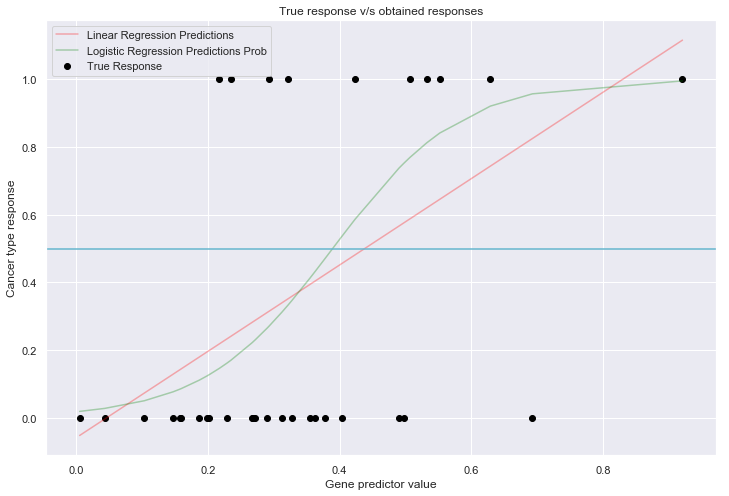

In [31]:
# your code here
plt.figure(figsize=(12,8))
sort_index = np.argsort(x_test['D29963_at'].values)

# plotting true binary response
plt.scatter(x_test['D29963_at'].iloc[sort_index], y_test.iloc[sort_index], color='black', label = 'True Response')

# plotting ols output
plt.plot(x_test['D29963_at'].iloc[sort_index], y_test_pred.iloc[sort_index], color='red', alpha=0.3, \
         label = 'Linear Regression Predictions')
# plt.plot(x_test['D29963_at'].iloc[sort_index], y_test_pred.iloc[sort_index]>0.5, color='red', ls='-.', \
#          label = 'Linear Regression Class Predictions ')


# plotting logreg prob output
plt.plot(x_test['D29963_at'].iloc[sort_index], y_test_pred_logreg_prob[sort_index], alpha=0.3,  \
         color='green', label = 'Logistic Regression Predictions Prob')
#plt.plot(x_test['D29963_at'].iloc[sort_index], y_test_pred_logreg[sort_index], color='green', ls='-.' ,label = 'Logistic Regression Predictions')

plt.axhline(0.5, c='c')
plt.legend()
plt.title('True response v/s obtained responses')
plt.xlabel('Gene predictor value')
plt.ylabel('Cancer type response');

Both models give similar outputs as can be observed from the plot above. However, we can see that Linear regression output goes below 0 and above 1 in some cases, whereas Logistic regression outputs are probability values between 0 and 1.

<div class='exercise'> <b> Question 3 [30pts]: Multiple Logistic Regression </b> </div>

In [32]:
#--------  visualize_prob
# A function to visualize the probabilities predicted by a Logistic Regression model
# Input: 
#      model (Logistic regression model)
#      x (n x d array of predictors in training data)
#      y (n x 1 array of response variable vals in training data: 0 or 1)
#      ax (an axis object to generate the plot)

def visualize_prob(model, x, y, ax):
    # Use the model to predict probabilities for x
    y_pred = model.predict_proba(x)
    
    # Separate the predictions on the label 1 and label 0 points
    ypos = y_pred[y==1]
    yneg = y_pred[y==0]
    
    # Count the number of label 1 and label 0 points
    npos = ypos.shape[0]
    nneg = yneg.shape[0]
    
    # Plot the probabilities on a vertical line at x = 0, 
    # with the positive points in blue and negative points in red
    pos_handle = ax.plot(np.zeros((npos,1)), ypos[:,1], 'bo', label = 'Cancer Type 1')
    neg_handle = ax.plot(np.zeros((nneg,1)), yneg[:,1], 'ro', label = 'Cancer Type 0')

    # Line to mark prob 0.5
    ax.axhline(y = 0.5, color = 'k', linestyle = '--')
    
    # Add y-label and legend, do not display x-axis, set y-axis limit
    ax.set_ylabel('Probability of AML class')
    ax.legend(loc = 'best')
    ax.get_xaxis().set_visible(False)
    ax.set_ylim([0,1])

**3.1:** Next, fit a multiple logistic regression model with all the gene predictors from the data set. How does the classification accuracy of this model compare with the models fitted in question 2 with a single gene (on both the training and test sets)?

In [33]:
# your code here
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# adding constant term
all_x_train = x_train #sm.add_constant(x_train)
all_x_test = x_test # sm.add_constant(x_test)
print(all_x_train.shape, all_x_test.shape)

# fitting multi regression model
multi_regr = LogisticRegression(C=100000, solver = "lbfgs")
multi_regr.fit(all_x_train, y_train)

# predictions
y_train_pred_multi = multi_regr.predict(all_x_train) 
y_test_pred_multi = multi_regr.predict(all_x_test)

# accuracy
train_score_multi = accuracy_score(y_train, y_train_pred_multi)
test_score_multi = accuracy_score(y_test, y_test_pred_multi)

print('Training set accuracy for multiple logistic regression = ', train_score_multi)
print('Test set accuracy for multiple logistic regression = ', test_score_multi)

(40, 7129) (40,)
(33, 7129) (33,)
(40, 7129) (33, 7129)
Training set accuracy for multiple logistic regression =  1.0
Test set accuracy for multiple logistic regression =  1.0


<font color='red'>
The multiple logistic regression accuracy for both train and test sets are perfect at 100%. This is an improvement from the Logistic regression accuracy with single predictors. However, the moral of the story here is that (1) because of the shortage of training samples, we are overfitting to noise in the training, and (2) because of the shortage of test samples and the high dimensionality of the data, we have no way of ascertaining the generalization capacity of any trained model - which could mislead us into a false sense of security on the accuracy of the model as a whole. 
</font>


**3.2** How many of the coefficients estimated by this multiple logistic regression in the previous part are significantly different from zero at a *significance level of 5%*? Use the same value of C=100000 as before.

**Hint:** To answer this question, use *bootstrapping* with 1000 boostrap samples/iterations.  

In [34]:
# bootstrapping code
# your code here
n = 1000 # Number of iterations
boot_coefs = np.zeros((all_x_train.shape[1],n)) # Create empty storage array for later use

# iteration for each sample
for i in range(n):
    # Sampling WITH replacement the indices of a resampled dataset 
    sample_index = np.random.choice(range(y_train.shape[0]), size=y_train.shape[0], replace=True)

    # finding subset
    x_train_samples = all_x_train.values[sample_index]
    y_train_samples = y_train.values[sample_index]
    
    # finding logreg coefficient
    logistic_mod_boot = LogisticRegression(C=100000, fit_intercept=True, solver = "lbfgs") 
    logistic_mod_boot.fit(x_train_samples, y_train_samples) 
    boot_coefs[:,i] = logistic_mod_boot.coef_

In [35]:
ci_upper = np.percentile(boot_coefs, 97.5, axis=1)
ci_lower = np.percentile(boot_coefs, 2.5, axis=1)

# ct significant predictors
sig_b_ct = 0
sig_preds = []
cols = list(x_train.columns)

# if ci contains 0, then insignificant
for i in range(len(ci_upper)):
    if ci_upper[i]<=0 or ci_lower[i]>=0:
            sig_b_ct += 1
            sig_preds.append(cols[i])

print("Significant coefficents at 5pct level = %i / %i" % (sig_b_ct, len(ci_upper)))
# print('Number of significant columns: ', len(sig_preds))

Significant coefficents at 5pct level = 1865 / 7129


Thus, we can see that only 1865 out of 7130 predictors are significantly different from 0 at a significance level of 5%.

**3.3** Use the `visualize_prob` function provided below (or any other visualization) to visualize the probabilties predicted by the fitted multiple logistic regression model on both the training and test data sets. The function creates a visualization that places the data points on a vertical line based on the predicted probabilities, with the different cancer classes shown in different colors, and with the 0.5 threshold highlighted using a dotted horizontal line. Is there a difference in the spread of probabilities in the training and test plots? Are there data points for which the predicted probability is close to 0.5? If so, what can you say about these points?

Text(0.5, 1.0, 'test set')

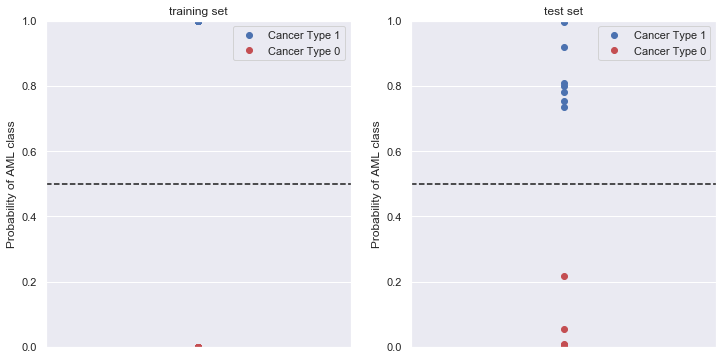

In [36]:
""" Plot classification model """
# your code here
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# visualising train set fit
visualize_prob(multi_regr, all_x_train, y_train, ax1)
ax1.set_title('training set')

# visualising test set fit
visualize_prob(multi_regr, all_x_test, y_test, ax2)
ax2.set_title('test set')

<font color='red'>
Difference in spread of probability - In the training set the predicted AML values are 1 and predicted ALL values are 0. In the test set, the probabilities are spread above 0.5 but closer to 0 for points below 0.5. <br/>

There are data points for which probability is close to 0.5, indicating that it cannot be determined clearly which type of cancer the patient has. They may give false positives or false negatives.
</font>

**3.4** Open question: Comment on the classification accuracy of tain and test set? Given the results above how would you assest the generalization capacity of your trained model? What other tests would you suggest to better guard against false sense of security on the accuracy of the model as a whole. 

The answer is always cross validation 

<div class='exercise'><b> Question 4 [20 pts]: PCR: Principal Components Regression </b></div>

High dimensional problems can lead to problematic behavior in model estimation (and make prediction on a test set worse), thus we often want to try to reduce the dimensionality of our problems. A reasonable approach to reduce the dimensionality of the data is to use PCA and fit a logistic regression model on the smallest set of principal components that explain at least 90% of the variance in the predictors.

**4.1** Fit two separate Logistic Regression models using principal components as the predictors: (1) with the number of components you selected from problem 1.5 and (2) with the number of components that explain at least 90% of the variability in the feature set. How do the classification accuracy values on both the training and tests sets compare with the models fit in question 3?

In [37]:
# Applying PCA 
pca = PCA(n_components=29) # from our result in 1.5
pca.fit(x_train)

# transforming train and test data for regression
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

In [38]:
logreg_pca = LogisticRegression(C=100000, fit_intercept=False)
logreg_pca.fit(x_train_pca, y_train)

y_train_pred_logreg_pca = logreg_pca.predict(x_train_pca)
y_test_pred_logreg_pca = logreg_pca.predict(x_test_pca)

train_score_logreg_pca = accuracy_score(y_train, y_train_pred_logreg_pca)
test_score_logreg_pca = accuracy_score(y_test, y_test_pred_logreg_pca)

print('Training set accuracy for Logistic Regression with PCA = ', train_score_logreg_pca)
print('Test set accuracy for Logistic Regression with PCA = ', test_score_logreg_pca)

Training set accuracy for Logistic Regression with PCA =  1.0
Test set accuracy for Logistic Regression with PCA =  0.9393939393939394


<font color='red'>
1. The first 20 principal components explain 90.26% of the total variance in data. <br/>
2. Logistic Regression on PCA components gives 100% train accuracy and 96.96% test accuracy. The train accuracy here is same as LogReg in 3.1 but test accuracy is slightly less tha Logreg. Since PCA components only explain 90% of the data, this makes intuitive sense. <br/>
</font>

**4.2:** Use the code provided in question 3 to visualize the probabilities predicted by the fitted models on both the training and test sets. How does the spread of probabilities in these plots compare to those for the model in question 3.2? If the lower dimensional representation yields comparable predictive power, what advantage does the lower dimensional representation provide?

Text(0.5, 1.0, 'test set')

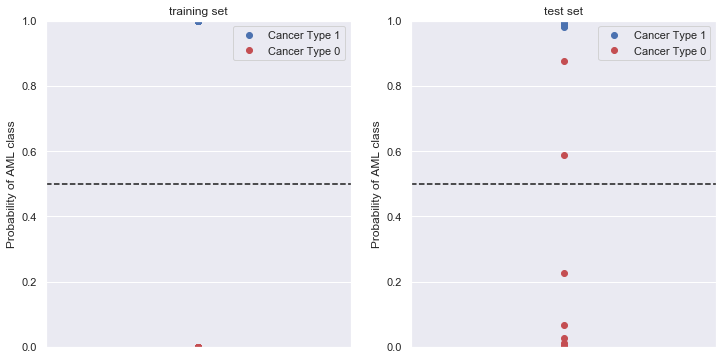

In [40]:
# your code here
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# visualising train set fit
visualize_prob(logreg_pca, x_train_pca, y_train, ax1)
ax1.set_title('training set')

# visualising test set fit
visualize_prob(logreg_pca, x_test_pca, y_test, ax2)
ax2.set_title('test set')


<font color='red'>
The spread of probabilities of the PCA model for the training set seems exactly the same as that for multiple logistic regression. In the case of the test set, cancer type 1 probabilities are closer to 1, which can be interpreted as greater certainty for Cancer type 1. Cancer type 0, on the other hand, shows greater spread in the PCA case as compared to the multiple logreg case. There are also cases where Cancer 0 is wrongly classified as Cancer 1, which was absent previously. <br/>

In summary, although the lower dimensional representation yields similar performance as the original multilog model, the computational cost is far lower due the order-of-magnitude difference in the number of features in the PCA-transformed data. It is also worth noting that while the PCA-transformed data has far fewer features than we did originally, this does not necessarily imply that this transformed dataset is more interpretable - the value of each principal component for a datapoint is yielded by a linear combination of the values of all of the original features.
</font>

In [41]:
# your code here
#--------  visualize_prob
# A function to visualize the probabilities predicted by a Logistic Regression model
# Input: 
#      model (Logistic regression model)
#      x (n x d array of predictors in training data)
#      y (n x 1 array of response variable vals in training data: 0 or 1)
#      ax (an axis object to generate the plot)

def visualize_prob_2(model1, model2, x1, y1, x2, y2, ax):
    # Use the model to predict probabilities for x
    y1_pred = model1.predict_proba(x1)
    y2_pred = model2.predict_proba(x2)
    
    # Separate the predictions on the label 1 and label 0 points
    ypos1 = y1_pred[y1==1]
    yneg1 = y1_pred[y1==0]
    ypos2 = y2_pred[y2==1]
    yneg2 = y2_pred[y2==0]
    
    # Count the number of label 1 and label 0 points
    npos1 = ypos1.shape[0]
    nneg1 = yneg1.shape[0]
    npos2 = ypos2.shape[0]
    nneg2 = yneg2.shape[0]
    
    
    # Plot the probabilities on a vertical line at x = 0, 
    # with the positive points in blue and negative points in red
    pos_handle = ax.plot(np.zeros((npos1,1))-0.1, ypos1[:,1], 'bo', label = 'MultReg Cancer Type 1')
    neg_handle = ax.plot(np.zeros((nneg1,1))-0.1, yneg1[:,1], 'ro', label = 'MultReg Cancer Type 0')
    pos_handle = ax.plot(np.zeros((npos1,1))+.1, ypos2[:,1], 'go', label = 'PCA Cancer Type 1')
    neg_handle = ax.plot(np.zeros((nneg1,1))+.1, yneg2[:,1], 'mo', label = 'PCA Cancer Type 0')


    # Line to mark prob 0.5
    ax.axhline(y = 0.5, color = 'k', linestyle = '--')
    
    # Add y-label and legend, do not display x-axis, set y-axis limit
    ax.set_ylabel('Probability of AML class')
    ax.legend(loc = 2)
    ax.get_xaxis().set_visible(False)
    ax.set_ylim([0,1])
    ax.set_xlim([-1,1])

We also present the above plot juxtaposed with our multireg classification for convenience:

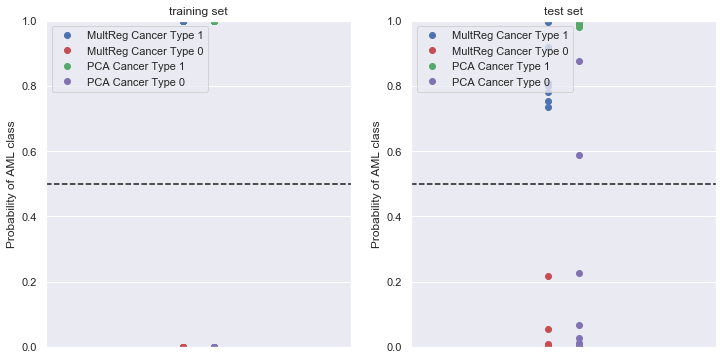

In [42]:
# your code here
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# visualising train set fit
visualize_prob_2(multi_regr, logreg_pca, all_x_train, y_train, x_train_pca, y_train, ax1)
ax1.set_title('training set')

# visualising test set fit
visualize_prob_2(multi_regr, logreg_pca, all_x_test, y_test, x_test_pca, y_test, ax2)
ax2.set_title('test set')
plt.show()